## Data Augmentation

### Transform :

我們有實作多種Transform的技巧如下所列，分成兩種，為改變圖形大小或形狀的，跟改變圖片色溫或加躁點等等的，跟改變圖片像素的

*    flip_horizontal
*    rotate
*    scale
*    translate
*    shear
*    brightness_contrast
*    blur
*    noise
*    color_temperature
*    cutout
接著會將這兩類的方式各別挑一種加到同一張圖片上，若不為新複製的圖片則不做augmentation。在`rotate` , `scale` ,`shear` 跟 `translate` 中會造成圖片有部分缺失，原本是填充黑色，但發現可能會影響到tvmonitor的判斷，所以改成用白色。

### Mosaic :

在本次Cup當中，有使用Mosaic的技術。Msaic是YOLOv4所提出的數據增強方法，其概念類似CutMix，也是將不同圖片做裁減過後拼接在一起的方法，但與CutMix不同的點在於，CutMix拼接後的圖片會遮蔽原圖片，在一定程度上可能會造成辨識變的困難。我們也有將Mosaic的data做balance，但一開始有發現若Mosaic的數量太多可能會導致model學壞，所以有控制Mosaic所產生的數量，並且若為了完全平衡可能導致重複生成很多個一樣的圖片。所以最後在把augmentation的數量提高到6000的情況下可以讓balacing維持在90%左右

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from collections import Counter, defaultdict
import random
import shutil

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Select GPU number 1
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
classes_name =  ["aeroplane", "bicycle", "bird", "boat", "bottle", 
                 "bus", "car", "cat", "chair", "cow", "diningtable", 
                 "dog", "horse", "motorbike", "person", "pottedplant", 
                 "sheep", "sofa", "train","tvmonitor"]

In [4]:
# common params
IMAGE_SIZE = 448
BATCH_SIZE = 8
NUM_CLASSES = 20
MAX_OBJECTS_PER_IMAGE = 20

# dataset params
DATA_PATH = './data/pascal_voc_training_data.txt'
IMAGE_DIR = './data/VOCdevkit_train/VOC2007/JPEGImages/'

#new dataset
NEW_DATA_PATH = './data/new_training_data.txt'
NEW_IMAGE_DIR = './data/new_JPEG/'
AUG_DATA_PATH = './data/aug_training_data.txt'
AUG_IMAGE_DIR = './data/aug_JPEG/'
target_count = 2000

In [5]:

def read_annotations(file_path):
    annotations = defaultdict(list)
    with open(file_path, 'r') as f:
        for line_number, line in enumerate(f, start=1):
            parts = line.strip().split()
            
            # 檢查是否有至少一個 bounding box（6 個元素）
            if len(parts) < 6 or (len(parts) - 1) % 5 != 0:
                print(f"Warning: Line {line_number} in {file_path} does not match the expected format. Skipping this line.")
                continue
            
            img_name = parts[0]
            try:
                # 每 5 個數據組成一個 bounding box (x_min, y_min, x_max, y_max, class_id)
                for i in range(1, len(parts), 5):
                    x_min, y_min, x_max, y_max, class_id = map(int, parts[i:i+5])
                    annotations[img_name].append((x_min, y_min, x_max, y_max, class_id))
            except ValueError as e:
                print(f"Error: Line {line_number} in {file_path} contains non-integer values. {e}")
                
    return annotations

def count_classes(annotations):
    class_counter = Counter([bbox[4] for boxes in annotations.values() for bbox in boxes])
    return class_counter

# 將所有原始資料複製到新的資料夾和 .txt 檔案，並進行補充
def copy_and_balance_data(annotations, source_folder, target_folder, target_txt_path, target_count):
    os.makedirs(target_folder, exist_ok=True)
    class_counts = count_classes(annotations)
    
    # 初始化新的 .txt 檔案
    with open(target_txt_path, "w") as target_file:
        # 先將所有原始圖片和標註資訊複製到新的資料夾和 .txt 檔案中
        for img_name, bboxes in annotations.items():
            source_img_path = os.path.join(source_folder, img_name)
            target_img_name = img_name
            target_img_path = os.path.join(target_folder, target_img_name)
            
            # 複製圖片
            if os.path.exists(source_img_path):
                shutil.copy2(source_img_path, target_img_path)
            
            # 將 bounding box 資訊寫入新的 .txt 檔案
            line = [target_img_name]
            for bbox in bboxes:
                x_min, y_min, x_max, y_max, class_id = bbox
                line.extend([str(x_min), str(y_min), str(x_max), str(y_max), str(class_id)])
            
            target_file.write(" ".join(line) + "\n")
        
        # 補充數量較少的類別
        while any(count < target_count for count in class_counts.values()):
            for img_name, bboxes in annotations.items():
                # 檢查這張圖片中的所有類別的數量是否都小於 target_count
                if all(class_counts[bbox[4]] < target_count for bbox in bboxes):
                    source_img_path = os.path.join(source_folder, img_name)
                    target_img_name = f"{img_name.split('.')[0]}_aug_{random.randint(1000,9999)}.jpg"  # 使用隨機數防止重名
                    target_img_path = os.path.join(target_folder, target_img_name)
                    
                    # 複製圖片
                    if os.path.exists(source_img_path):
                        shutil.copy2(source_img_path, target_img_path)
                    
                    # 將 bounding box 資訊寫入新的 .txt 檔案，保持格式一致
                    line = [target_img_name]
                    for bbox in bboxes:
                        x_min, y_min, x_max, y_max, class_id = bbox
                        line.extend([str(x_min), str(y_min), str(x_max), str(y_max), str(class_id)])
                        # 更新 class_counts
                        class_counts[class_id] += 1
                    
                    target_file.write(" ".join(line) + "\n")
                    
                    # 檢查是否達到目標數量
                    if all(count >= target_count for count in class_counts.values()):
                        print("All classes have reached the target count.")
                        return


In [6]:
# annotations = read_annotations(DATA_PATH)
# class_counts = count_classes(annotations)
# print(class_counts)
# copy_and_balance_data(annotations, IMAGE_DIR, NEW_IMAGE_DIR, NEW_DATA_PATH, target_count)
annotations = read_annotations(NEW_DATA_PATH)
class_counts = count_classes(annotations)
print(class_counts)

Counter({14: 5392, 6: 1636, 8: 1425, 16: 1012, 4: 1010, 2: 1008, 0: 1003, 15: 1002, 9: 1002, 5: 1001, 12: 1000, 1: 1000, 7: 1000, 11: 1000, 18: 1000, 10: 1000, 19: 1000, 13: 1000, 3: 1000, 17: 1000})


In [6]:
# 定義各個增強函數
def flip_horizontal(image, bboxes):

    flipped_image = cv2.flip(image, 1)
    h, w = image.shape[:2]
    flipped_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        flipped_bbox = [w - x_max, y_min, w - x_min, y_max]
        flipped_bboxes.append(flipped_bbox)
    return flipped_image, flipped_bboxes

def rotate_image_and_bboxes(image, bboxes, angle):
    h, w = image.shape[:2]
    # 計算旋轉矩陣
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # 旋轉圖像，保持原始尺寸
    rotated_image = cv2.warpAffine(image, M, (w, h), borderValue=(255, 255, 255))

    # 旋轉邊界框
    rotated_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        corners = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])
        ones = np.ones((corners.shape[0], 1))
        corners_ones = np.hstack([corners, ones])
        transformed_corners = M.dot(corners_ones.T).T
        x_coords = transformed_corners[:, 0]
        y_coords = transformed_corners[:, 1]
        x_min_new = x_coords.min()
        y_min_new = y_coords.min()
        x_max_new = x_coords.max()
        y_max_new = y_coords.max()
        rotated_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])

    return rotated_image, rotated_bboxes

def scale_image_and_bboxes(image, bboxes, scale_factor_x, scale_factor_y):

    h, w = image.shape[:2]
    new_w = int(w * scale_factor_x)
    new_h = int(h * scale_factor_y)
    scaled_image = cv2.resize(image, (new_w, new_h))
    scaled_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_min_new = x_min * scale_factor_x
        y_min_new = y_min * scale_factor_y
        x_max_new = min(x_max * scale_factor_x , w)
        y_max_new = min(y_max * scale_factor_y , h)
        scaled_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])

    canvas = np.ones(image.shape, dtype=np.uint8) * 255

    y_lim = int(min(scale_factor_y, 1) * image.shape[0])
    x_lim = int(min(scale_factor_x, 1) * image.shape[1])

    canvas[:y_lim, :x_lim, :] = scaled_image[:y_lim, :x_lim, :]

    scaled_image = canvas
    return scaled_image, scaled_bboxes

def translate_image_and_bboxes(image, bboxes):
  
    h, w = image.shape[:2]

    min_xmin = min([bbox[0] for bbox in bboxes])
    max_xmax = max([bbox[2] for bbox in bboxes])
    max_left_trans = min_xmin
    max_right_trans = w - max_xmax

    min_ymin = min([bbox[1] for bbox in bboxes])
    max_ymax = max([bbox[3] for bbox in bboxes])
    max_up_trans = min_ymin
    max_down_trans = h - max_ymax

    if max_left_trans == 0 and max_right_trans == 0 and max_up_trans == 0 and max_down_trans == 0:
        return image, bboxes
    

    tx = random.uniform(max(-max_left_trans , -image.shape[1] * 0.2), min(max_right_trans , image.shape[1] * 0.2))
    ty = random.uniform(max(-max_up_trans , -image.shape[0] * 0.2), min(max_down_trans , image.shape[0] * 0.2))

    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated_image = cv2.warpAffine(image, M, (w, h) , borderValue=(255, 255, 255)) 
    translated_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        x_min_new = x_min + tx
        y_min_new = y_min + ty
        x_max_new = x_max + tx
        y_max_new = y_max + ty
        translated_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])
    return translated_image, translated_bboxes

def shear_image_and_bboxes(image, bboxes):
    shear_factor_x = random.uniform(-0.15 , 0.15)
    shear_factor_y = random.uniform(-0.15 , 0.15)

    h, w = image.shape[:2]
    # Construct shear matrix
    M = np.array([[1, shear_factor_x, 0], [shear_factor_y, 1, 0]], dtype=np.float32)
    # Calculate new dimensions to fit the sheared image
    nW = int(w + abs(shear_factor_y) * h)
    nH = int(h + abs(shear_factor_x) * w)
    # Apply the shear transformation
    sheared_image = cv2.warpAffine(image, M, (nW, nH), borderValue=(255, 255, 255))
    # Adjust bounding boxes
    sheared_bboxes = []
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        # Define bounding box corners
        corners = np.array([
            [x_min, y_min],
            [x_max, y_min],
            [x_max, y_max],
            [x_min, y_max]
        ])
        # Apply the shear transformation to the corners
        transformed_corners = np.dot(corners, M[:2, :2].T) + M[:2, 2]

        # Extract the new bounding box coordinates
        x_coords = transformed_corners[:, 0]
        y_coords = transformed_corners[:, 1]
        x_min_new = x_coords.min()
        y_min_new = y_coords.min()
        x_max_new = x_coords.max()
        y_max_new = y_coords.max()

        sheared_bboxes.append([x_min_new, y_min_new, x_max_new, y_max_new])
    return sheared_image, sheared_bboxes

def adjust_brightness_contrast(image):
    
    alpha = random.uniform(0.8, 1.2)  # 對比度
    beta = random.uniform(-30, 30)    # 亮度
    adjusted_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return adjusted_image

def apply_blur(image):
    blur_types = ['average', 'gaussian', 'median', 'bilateral']
    blur_type = random.choice(blur_types)

    if blur_type == 'average':
        ksize = random.choice([3, 5])
        blurred_image = cv2.blur(image, (ksize, ksize))
    elif blur_type == 'gaussian':
        ksize = random.choice([3, 5])
        blurred_image = cv2.GaussianBlur(image, (ksize, ksize), 0)
    elif blur_type == 'median':
        ksize = random.choice([3, 5])
        blurred_image = cv2.medianBlur(image, ksize)
    elif blur_type == 'bilateral':
        d = random.randint(3, 5)
        sigmaColor = random.randint(50, 100)
        sigmaSpace = random.randint(50, 100)
        blurred_image = cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)
    else:
        blurred_image = image.copy()

    return blurred_image

def apply_noise(image):
    std_dev = random.uniform(0.5, 1.5) 
    noise = np.random.normal(0, std_dev, image.shape).astype(np.uint8)
    noisy_image = image.astype(np.int16) + noise * 0.4
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    return noisy_image

def apply_color_temperature(image , positive_range=(15, 25), negative_range=(-25, -15)):

    if random.choice([True, False]):
        temperature_shift = random.randint(*positive_range)  # Warmer tone
    else:
        temperature_shift = random.randint(*negative_range)  # Cooler tone
    # Convert image to float32 for more precise manipulation
    image = image.astype(np.float32)
    # Create a warming or cooling effect by modifying the RGB channels
    if temperature_shift > 0:  # Warmer tone
        image[:, :, 0] -= temperature_shift  # Decrease blue
        image[:, :, 2] += temperature_shift  # Increase red
    else:  # Cooler tone
        image[:, :, 0] += abs(temperature_shift)  # Increase blue
        image[:, :, 2] -= abs(temperature_shift)  # Decrease red

    # Clip the values to keep within valid range
    image = np.clip(image, 0, 255).astype(np.uint8)

    return image

def cutout(image):
    h, w = image.shape[:2]
    num_cutouts = random.randint(5 , 10)
    for _ in range(num_cutouts):
        # Dynamically select the size of the mask
        mask_size = 20
        
        # Randomly choose the center of the cutout
        cx = np.random.randint(w)
        cy = np.random.randint(h)
        
        # Calculate cutout corners and clip to image boundaries
        x1 = np.clip(cx - mask_size // 2, 0, w)
        y1 = np.clip(cy - mask_size // 2, 0, h)
        x2 = np.clip(cx + mask_size // 2, 0, w)
        y2 = np.clip(cy + mask_size // 2, 0, h)
        
        # Apply the cutout
        image[y1:y2, x1:x2] = 255  # White cutout region
    
    return image

In [ ]:
def random_augment_and_replace_images(image_folder, data_path, output_image_folder, output_data_path,
                                      augmentations_to_apply=None):
    
    if os.path.exists(output_image_folder):
        shutil.rmtree(output_image_folder)
        os.makedirs(output_image_folder)
    else:
    # 如果資料夾不存在，則創建
        os.makedirs(output_image_folder)

    # 定義可用的增強操作
    available_augmentations = {
        'flip_horizontal': flip_horizontal,
        'rotate': rotate_image_and_bboxes,
        'scale': scale_image_and_bboxes,
        'translate': translate_image_and_bboxes,
        'shear' :shear_image_and_bboxes,
        'brightness_contrast': adjust_brightness_contrast,
        'blur': apply_blur,
        'noise': apply_noise,
        'color_temperature':apply_color_temperature,
        'cutout' : cutout,
    }

    # 如果未指定要應用的增強操作，則默認使用所有可用的增強操作
    if augmentations_to_apply is None:
        augmentations_to_apply = list(available_augmentations.keys())

    # 讀取數據檔案
    with open(data_path, 'r') as f:
        lines = f.readlines()

    new_annotations = []
    
    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        bbox_data = parts[1:]

        # 解析邊界框和類別資訊
        bboxes = []
        category_ids = []
        for i in range(0, len(bbox_data), 5):
            x_min = float(bbox_data[i])
            y_min = float(bbox_data[i+1])
            x_max = float(bbox_data[i+2])
            y_max = float(bbox_data[i+3])
            cls = int(bbox_data[i+4])
            bboxes.append([x_min, y_min, x_max, y_max])
            category_ids.append(cls)

        # 讀取圖片
        image_path = os.path.join(image_folder, filename)
        output_image_path = os.path.join(output_image_folder, filename)
        image = cv2.imread(image_path)
        if image is None:
            continue

        # 隨機數據增強
        augmented_image = image.copy()
        augmented_bboxes = bboxes.copy()

        shape_altering_augs = ['rotate', 'scale' , 'translate' , 'flip_horizontal'  , 'shear']
        content_altering_augs = ['brightness_contrast', 'blur', 'noise' , 'color_temperature' , 'cutout']
        if '_aug_' in filename:
            chosen_augmentations = [random.choice(shape_altering_augs) , random.choice(content_altering_augs)]
        else:
            chosen_augmentations = []
            

        # 隨機選擇要應用的增強操作
        for aug in chosen_augmentations:
            if aug in available_augmentations:
                augmentation_func = available_augmentations[aug]
                if aug in ['rotate', 'scale']:
                    # 需要額外的參數
                    if aug == 'rotate':
                        if random.choice([True, False]):
                            angle = random.uniform(-30, -15)
                        else:
                            angle = random.uniform(15, 30)
                        augmented_image, augmented_bboxes = augmentation_func(augmented_image, augmented_bboxes, angle)
                    elif aug == 'scale':
                        scale_factor_x = random.uniform(0.8, 1.2)
                        scale_factor_y = random.uniform(0.8, 1.2)
                        augmented_image, augmented_bboxes = augmentation_func(augmented_image, augmented_bboxes, scale_factor_x, scale_factor_y)
                elif aug == 'translate' or aug == 'shear':
                    augmented_image, augmented_bboxes = augmentation_func(augmented_image, augmented_bboxes)
                elif aug == 'brightness_contrast' or aug == 'blur' or aug == 'noise' or aug == 'color_temperature' or aug == 'cutout':
                    augmented_image = augmentation_func(augmented_image)

        valid_bboxes = []
        valid_category_ids = []
        for bbox, cls in zip(augmented_bboxes, category_ids):
            x_min, y_min, x_max, y_max = bbox
            x_min = max(0, min(x_min, augmented_image.shape[1] - 1))
            y_min = max(0, min(y_min, augmented_image.shape[0] - 1))
            x_max = max(0, min(x_max, augmented_image.shape[1] - 1))
            y_max = max(0, min(y_max, augmented_image.shape[0] - 1))

            if x_max > x_min and y_max > y_min:
                valid_bboxes.append([x_min, y_min, x_max, y_max])
                valid_category_ids.append(cls)

        # 如果沒有有效的邊界框，跳過該圖像
        if len(valid_bboxes) == 0:
            continue

        # 保存增強後的圖片（覆蓋原始圖片）
        cv2.imwrite(output_image_path, augmented_image)

        # 準備新的註釋行
        annotation_line = [filename]
        for bbox, cls in zip(valid_bboxes, valid_category_ids):
            x_min, y_min, x_max, y_max = bbox
            annotation_line.extend([str(int(round(x_min))), str(int(round(y_min))),
                                    str(int(round(x_max))), str(int(round(y_max))), str(cls)])
        new_annotations.append(' '.join(annotation_line))

    # 將新的註釋資訊寫入文件
    with open(output_data_path, 'w') as f:
        for annotation in new_annotations:
            f.write(annotation + '\n')

In [14]:
# for i in range(10):
#     np_img = cv2.imread('./data/VOCdevkit_train/VOC2007/JPEGImages/000005.jpg')
#     np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
#     np_img = cutout(np_img)
#     plt.imshow(np_img)
#     plt.axis("off")
#     plt.show()

In [15]:
random_augment_and_replace_images(NEW_IMAGE_DIR, NEW_DATA_PATH , AUG_IMAGE_DIR , AUG_DATA_PATH)

In [16]:
annotations = read_annotations(NEW_DATA_PATH)
class_counts = count_classes(annotations)
print(class_counts)
annotations = read_annotations(AUG_DATA_PATH)
class_counts = count_classes(annotations)
print(class_counts)

Counter({14: 5392, 6: 1636, 8: 1425, 16: 1012, 4: 1010, 2: 1008, 0: 1003, 15: 1002, 9: 1002, 5: 1001, 12: 1000, 1: 1000, 7: 1000, 11: 1000, 18: 1000, 10: 1000, 19: 1000, 13: 1000, 3: 1000, 17: 1000})
Counter({14: 5392, 6: 1636, 8: 1425, 16: 1012, 4: 1010, 2: 1008, 0: 1003, 15: 1002, 9: 1002, 5: 1001, 12: 1000, 1: 1000, 7: 1000, 11: 1000, 18: 1000, 10: 1000, 19: 1000, 13: 1000, 3: 1000, 17: 1000})


In [12]:
def show_visualization_multiple_boxes(image_path, boxes, classes_name):
    """
    显示图片并在图片上画出多个边界框和物件类别。
    
    :param image_path: 图片的路径
    :param boxes: 包含每个物件的 bounding box 信息，格式为 [(xmin, ymin, xmax, ymax, class_num), ...]
    :param classes_name: 类别名称列表，用于将类别编号映射为名称
    """
    # 读取图片
    np_img = cv2.imread(image_path)
    if np_img is None:
        print("Error: Unable to load image at path:", image_path)
        return
    
    # 调整图片大小并转换颜色
    IMAGE_SIZE = 448  # 设置为所需的图像大小
    resized_img = cv2.resize(np_img, (IMAGE_SIZE, IMAGE_SIZE))
    resized_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)

    # 绘制每个边界框
    for (xmin, ymin, xmax, ymax, class_num) in boxes:
        # 获取类别名称
        class_name = classes_name[class_num]

        # 绘制边界框
        cv2.rectangle(resized_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 255), 2)
        
        # 绘制类别标签
        cv2.putText(resized_img, class_name, (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)

    # 显示图片
    print(resized_img.shape)
    filename = os.path.basename(image_path)
    print(filename)
    plt.imshow(resized_img)
    plt.axis("off")
    plt.show()

def read_annotations(data_path):
    annotations = {}
    with open(data_path, 'r') as f:
        lines = f.readlines()
    for line in lines:
        parts = line.strip().split()
        filename = parts[0]
        bbox_data = parts[1:]
        boxes = []
        for i in range(0, len(bbox_data), 5):
            xmin = float(bbox_data[i])
            ymin = float(bbox_data[i + 1])
            xmax = float(bbox_data[i + 2])
            ymax = float(bbox_data[i + 3])
            class_num = int(bbox_data[i + 4])
            boxes.append((xmin, ymin, xmax, ymax, class_num))
        annotations[filename] = boxes
    return annotations

# 主程序：随机选择图片进行可视化
def visualize_random_images(image_folder, data_path, num_images):
    annotations = read_annotations(data_path)
    image_names = list(annotations.keys())
    random.shuffle(image_names)
    selected_images = image_names[:num_images]
    for image_name in selected_images:
        image_path = os.path.join(image_folder, image_name)
        boxes = annotations[image_name]
        print(image_name)
        show_visualization_multiple_boxes(image_path, boxes, classes_name)



(375, 500, 3)
003419.jpg


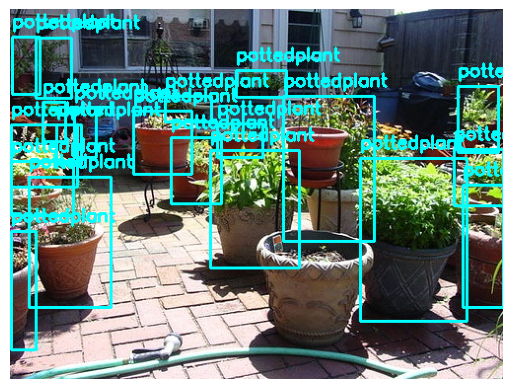

In [ ]:
# annotations = read_annotations(DATA_PATH)
# image_path = './data/VOCdevkit_train/VOC2007/JPEGImages/003419.jpg'
# boxes = annotations['003419.jpg']
# show_visualization_multiple_boxes(image_path, boxes, classes_name)


009636_aug_2114.jpg
(519, 415, 3)
009636_aug_2114.jpg


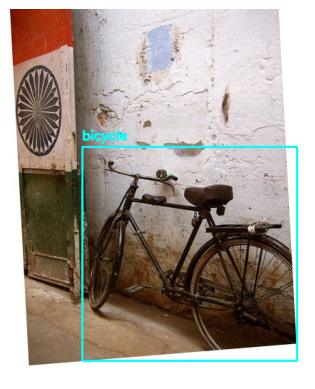

006565.jpg
(443, 553, 3)
006565.jpg


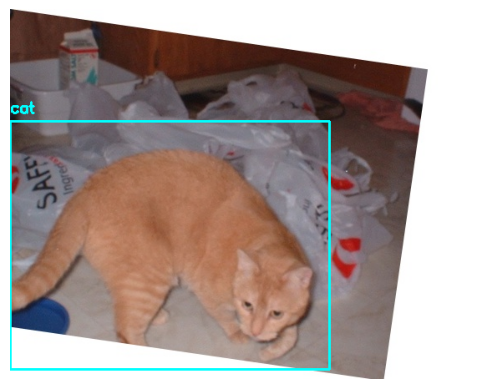

002043_aug_7153.jpg
(554, 522, 3)
002043_aug_7153.jpg


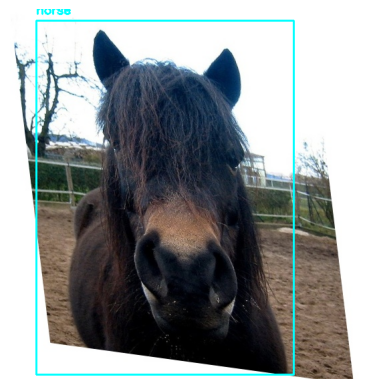

009877.jpg
(531, 362, 3)
009877.jpg


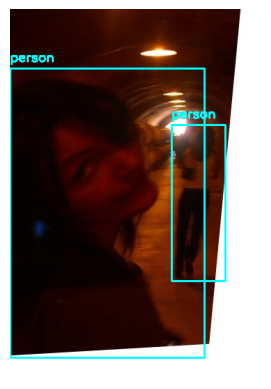

005805_aug_3963.jpg
(399, 507, 3)
005805_aug_3963.jpg


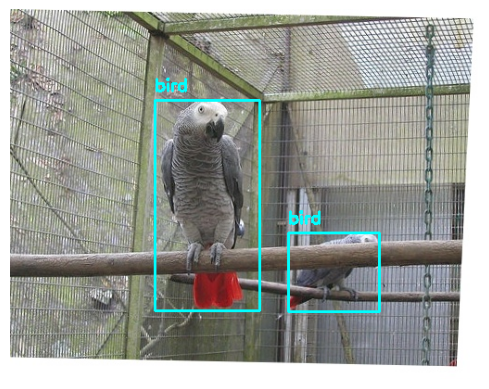

000381.jpg
(529, 424, 3)
000381.jpg


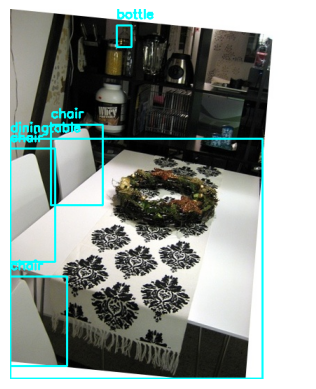

007050_aug_1366.jpg
(371, 524, 3)
007050_aug_1366.jpg


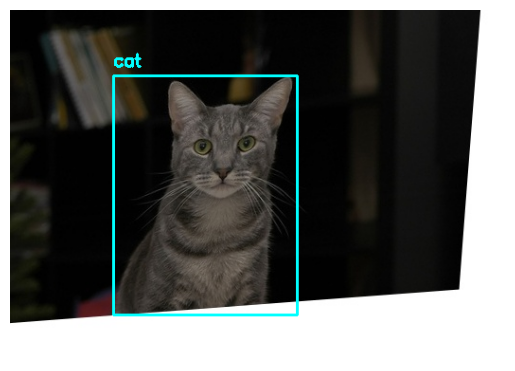

007773_aug_7490.jpg
(334, 534, 3)
007773_aug_7490.jpg


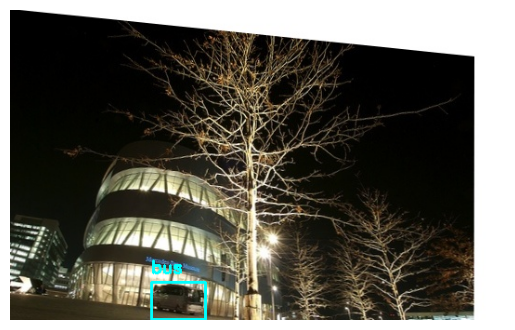

002352_aug_8305.jpg
(229, 527, 3)
002352_aug_8305.jpg


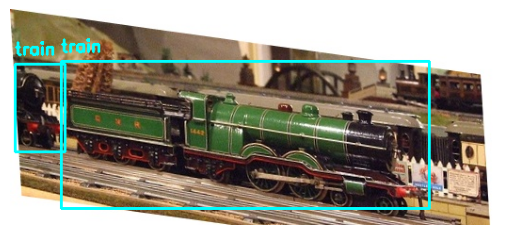

001752_aug_6516.jpg
(540, 426, 3)
001752_aug_6516.jpg


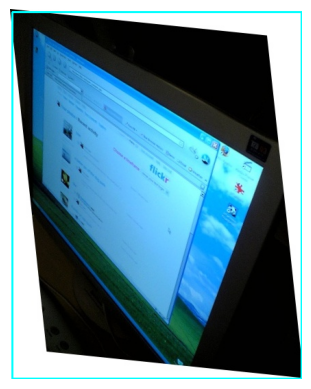

In [174]:
visualize_random_images(AUG_IMAGE_DIR, AUG_DATA_PATH, num_images = 10)